# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from collections import Counter

from tqdm.notebook import tqdm

import torch
from torch import functional as F
from torch import nn
from torch import optim

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


SEED = 42

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:1' if use_cuda else 'cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [2]:
class CBOWBatcher:
    def __init__(
        self, corpus, window_size, batch_size,
        vocabulary_size=20000
    ):
        self.corpus = corpus
        self.window_size = window_size
        self.batch_size = batch_size
        self.unk_token = '<UNK>'
        self.word2index = {
            word: index for index, (word, _)
            in enumerate(sorted(Counter(
                self.corpus
            ).items(), key=lambda x: x[1], reverse=True)[:vocabulary_size-1])
        }
        self.word2index[self.unk_token] = len(self.word2index)
        self.index2word = {
            index: word for word, index in self.word2index.items()
        }
        
    def __iter__(self):
        self.permutation = np.random.permutation(
            np.arange(self.window_size, len(self.corpus) - self.window_size)
        )
        self.batch_number = 0
        return self
    
    def __next__(self):
        if self.batch_number < len(self.permutation) / self.batch_size:
            X = np.array(
                [
                    [
                        self.word2index.get(self.corpus[j], self.word2index[self.unk_token])
                        for j in range(i - self.window_size, i + self.window_size + 1)
                        if j != i
                    ] for i in self.permutation[self.batch_number * self.batch_size:
                                                (self.batch_number + 1) * self.batch_size]
                ]
            )
        
            y = np.array(
                [
                    self.word2index.get(self.corpus[i], self.word2index[self.unk_token])
                    for i in self.permutation[self.batch_number * self.batch_size:
                                                (self.batch_number + 1) * self.batch_size]
                ]
            )
            self.batch_number += 1
            return X, y
        else:
            raise StopIteration

In [3]:
with open('text8') as inf:
    corpus = inf.read().split()

In [4]:
class CBOWNet(nn.Module):
    def __init__(self, vocabulary_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocabulary_size)
    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [5]:
WINDOW_SIZE = 2
BATCH_SIZE = 25000
VOCABULARY_SIZE = 20000
HIDDEN_SIZE = 300
LEARNING_RATE=1e-3
EPOCHS = 20
PATH = 'model.pth'

batcher = CBOWBatcher(corpus, WINDOW_SIZE, BATCH_SIZE, vocabulary_size=VOCABULARY_SIZE)

model = CBOWNet(VOCABULARY_SIZE, HIDDEN_SIZE).to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
)

steps_per_epoch = ceil((len(corpus) - 2 * WINDOW_SIZE) / BATCH_SIZE)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    LEARNING_RATE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch
)

train_losses = []

t_epochs = tqdm(range(EPOCHS))
for epoch in t_epochs:
    avg_epoch_loss = 0
    t_batches = tqdm(
        enumerate(batcher),
        total=steps_per_epoch,
        leave=False
    )

    for i, (X_batch, y_batch) in t_batches:
        X_batch_tensor = torch.from_numpy(X_batch).to(
            device=device, non_blocking=True
        )
        y_batch_tensor = torch.from_numpy(y_batch).to(
            device=device, non_blocking=True
        )
        optimizer.zero_grad()
        loss = criterion(model(X_batch_tensor), y_batch_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        avg_epoch_loss += loss.item() / (len(corpus) - 2 * WINDOW_SIZE)
        t_batches.set_postfix(loss=loss.item() / BATCH_SIZE)

    train_losses.append(avg_epoch_loss)
    t_epochs.set_postfix(avg_loss=avg_epoch_loss)

torch.save(model.state_dict(), PATH)

1 hour and 30 minutes to train model

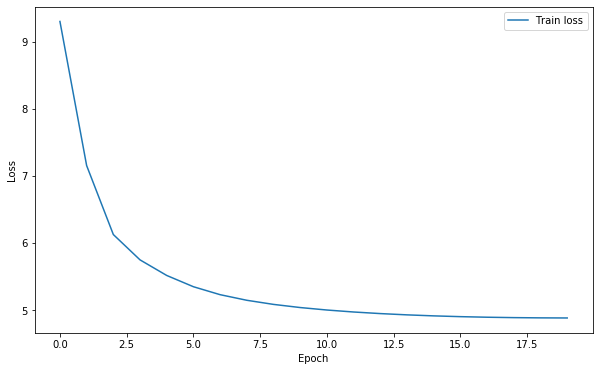

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [7]:
# Word2Vec class instead of function to map token to corresponding word vector
class Word2Vec:
    def __init__(self, word2index, embedding):
        self.word2index = word2index
        self.index2word = {
            index: word for word, index in self.word2index.items()
        }
        self.embedding = embedding
        self.unk_token = '<UNK>'
        self.similarity_matrix = cosine_similarity(embedding)
    def __getitem__(self, key):
        return self.embedding[
            self.word2index.get(key, self.word2index[self.unk_token])
        ]
    def most_similar(self, word):
        if word in self.word2index:
            indices = self.similarity_matrix[self.word2index[word]].argsort()[-2:-12:-1]
            return [self.index2word[i] for i in indices]
        else:
            return []
    def analogy(self, source_1, target_1, source_2):
        target_vector = self[target_1] - self[source_1] + self[source_2]
        indices = cosine_similarity(
            target_vector.reshape(1, -1), self.embedding
        )[0].argsort()[:-11:-1]
        return [self.index2word[i] for i in indices
                if self.index2word[i] not in [source_1, target_1, source_2] ][:10]
        

embedding = (model.embedding.weight.detach() + model.fc.weight.detach()).cpu().numpy()

w2v = Word2Vec(batcher.word2index, embedding)

In [8]:
w2v['linux']

array([-0.8068449 ,  1.0661669 ,  2.6364682 , -2.2254546 ,  0.08887216,
       -0.9300101 ,  0.3850382 , -1.099132  ,  1.9747189 , -1.8135585 ,
       -0.73640186, -0.04200182, -1.4479333 ,  0.49193245, -0.6605276 ,
       -1.754659  , -0.6840506 , -0.14055148,  0.4998796 , -0.3550422 ,
        0.01035576,  0.13048284,  1.7606828 ,  0.6318434 , -1.6843998 ,
        0.9766246 , -0.8847854 , -2.330689  ,  1.7210213 , -0.52473277,
        1.7725825 , -0.27723286,  1.2183839 , -0.81302303, -0.14269236,
       -2.3941908 , -1.0587066 ,  0.26370534,  0.03946093, -0.82252914,
       -0.31202522,  0.19829679, -1.5965699 ,  0.49285156, -0.21585202,
       -0.90457505,  0.09006976, -0.25926182, -0.5196236 , -1.7996289 ,
        1.8644801 , -0.4856276 ,  1.5110195 ,  0.2623674 , -0.06879294,
       -0.9323941 , -3.1061027 , -0.2603523 ,  0.33046308,  0.00804608,
        0.81398517,  1.0309944 , -0.13247102, -0.18465135, -0.93599033,
       -0.02921748,  0.4388265 ,  1.3139098 , -1.528191  ,  0.02

In [9]:
w2v.most_similar('linux')

['freebsd',
 'windows',
 'unix',
 'software',
 'gpl',
 'gnu',
 'proprietary',
 'distributions',
 'debian',
 'gnome']

In [10]:
w2v.analogy('athens', 'greece', 'baghdad')  # Iraq

['serbia',
 'iraq',
 'mozambique',
 'providers',
 'iceland',
 'yugoslavia',
 'thailand',
 'ghana']

In [11]:
w2v.analogy('moscow', 'russia', 'oslo')  # Norway

['norway',
 'ukraine',
 'kazakhstan',
 'hungary',
 'croatia',
 'turkey',
 'censors',
 'yes']

In [12]:
embedding_reduced = TSNE(n_components=2).fit_transform(embedding)

In [13]:
def plot_embeddings(embedding_reduced, index2word, indices):
    plt.figure(figsize=(16, 10))
    for i in indices:
        plt.scatter(*embedding_reduced[i], marker='x', color='red')
        plt.text(*embedding_reduced[i], index2word[i], fontsize=9)
    plt.show()

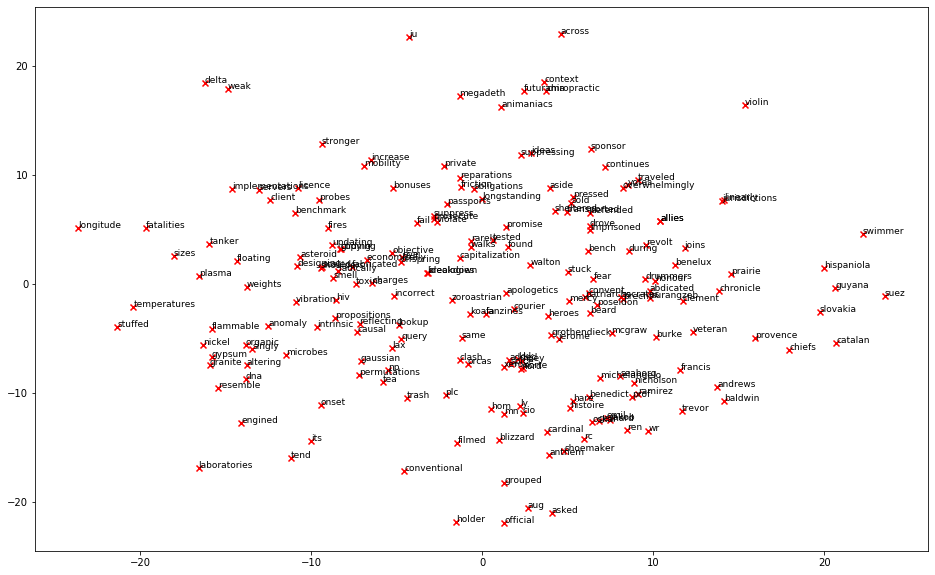

In [19]:
indices = np.random.randint(VOCABULARY_SIZE, size=200)
plot_embeddings(embedding_reduced, w2v.index2word, indices)

In [25]:
with open('questions-words.txt') as inf:
    correct_top1 = correct_top10 = queries_count = 0
    for line in inf:
        query = line.lower().split()
        if len(query) == 4:
            answer = w2v.analogy(*query[:3])
            correct_top1 += query[-1] == answer[0]
            correct_top10 += query[-1] in answer
            queries_count += 1

In [26]:
print(f'Top1 accuracy: {correct_top1/queries_count:.2%}')
print(f'Top10 accuracy: {correct_top10/queries_count:.2%}')

Top1 accuracy: 5.76%
Top10 accuracy: 15.81%
